In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt
from numpy import pi

In [2]:
def Plot_state(x,dx,th,dth,t):
    fig, axs = plt.subplots(2, 2, figsize = (12,10))
    axs[0,0].plot(t, x)
    axs[0,0].set_xlabel('time')
    axs[0,0].set_ylabel('position')
    axs[0,0].set_title("Position of Cart")
    axs[0,0].grid(True)

    axs[0,1].plot(t, dx)
    axs[0,1].set_xlabel('time')
    axs[0,1].set_ylabel('velocity')
    axs[0,1].set_title("Velocity Cart")
    axs[0,1].grid(True)

    axs[1,0].plot(t, th)
    axs[1,0].set_xlabel('time')
    axs[1,0].set_ylabel('angle')
    axs[1,0].set_title("Angle of Pendulum")
    axs[1,0].grid(True)

    axs[1,1].plot(t, dth)
    axs[1,1].set_xlabel('time')
    axs[1,1].set_ylabel('omega')
    axs[1,1].set_title("Omega of Pendulum")
    axs[1,1].grid(True)

In [3]:
class Pendulum_Linear:
    def __init__(self, A,B,C,D, x0=None):
        self.Gss = control.ss(A,B,C,D)
        self.state = x0
        self.state = np.zeros((self.Gss.A.shape[0], 1)) if x0 is None else x0
        self.change_state(self.state)
        
    def change_input(self,F):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(F)
        self.output = np.array([self.y[0, 0],self.y[1,0],self.y[2,0], self.y[3,0]]) 

    def change_state(self,x):
        self.x = self.state = x
    
    def derivative(self,input):
        self.change_input(input)
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)

In [4]:
#modelling of dc motor, V as input and F as output
class Motor:
    def __init__(self, J,b,R,L,k,r):
        self.J = J
        self.b = b 
        self.R = R
        self.L = L
        self.k = k
        self.r = r
        self.Gss = self.get_Gss()
        self.state = np.array([[0],[0],[0]])
        self.change_state(self.state)
        

    def change_input(self,V):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(V)
        self.output = self.y[0,0]

    def change_state(self,x):
        self.x = self.state = x

    def derivative(self,input):
        self.change_input(input)
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)
    
    def get_Gss(self):
        A = np.array([[0,1,0],
                        [0,-self.b/self.J,self.k/self.J],
                        [0, -self.k/self.L, -self.R/self.L]])
        B = np.array([[0],[0],[1/self.L]])
        C = np.array([[0,(-self.k*self.k/(self.R*self.r)),0]])
        D = np.array([[self.k/(self.R*self.r)]])
        return control.ss(A,B,C,D)

In [5]:
# physical constants
M = 0.5;
m = 0.2;
b = 0.2;
I = 0.0034;
g = 9.8;
l = 0.3;

#motor parameter
k = 0.5 # motor torque constant
R = 6.5 # motor resistance
r = 0.05   # shaft radius
J = 0.0001
L = 0.1*10**(-6)

In [6]:
p = I*(M+m)+M*m*l**2;


A = np.array([[0   ,   1    ,          0   ,        0],
              [0 , -(I+m*l**2)*b/p , (m**2*g*l**2)/p ,  0],
              [0 ,     0         ,     0    ,       1],
              [0 , -(m*l*b)/p   ,    m*g*l*(M+m)/p , 0]])

B = np.array([[0],
          [(I+m*l**2)/p],
          [0],
          [m*l/p]])
C = np.array([0 ,0 ,1 ,0]) #we are concerned for only angle
D = 0.0

In [164]:
pendulum = Pendulum_Linear(A,B,C,D)
motor = Motor(J=0.001,b=0.1,R=5,L=0.005,k=0.01,r=0.05)
MP_Gss = control.series(motor.Gss,pendulum.Gss)
A_mp = MP_Gss.A
B_mp = MP_Gss.B
C_mp = MP_Gss.C
D_mp = MP_Gss.D

In [8]:
O = control.obsv(A_mp, C_mp)

In [9]:
np.linalg.matrix_rank(O)

5

In [10]:
class motor_pendulum:
    def __init__(self,A,B,C,D,x0 = None):
        self.n = A.shape[0]
        self.Gss= control.ss(A,B,C,D)
        self.state = np.zeros((self.n, 1)) if x0 is None else x0 
        self.change_state(self.state)

    def change_input(self,u):
        self.y = np.matmul(self.Gss.C,self.x) + self.Gss.D*(u)
        self.output = self.y 

    def change_state(self,x):
        self.x = self.state = x

    def derivative(self,input):
        self.change_input(input)
        return np.matmul(self.Gss.A,self.x) + self.Gss.B*(input)

In [11]:
class Full_State_Estimater:
    def __init__(self,A,B,C,D, poles):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.x_hat = np.zeros((A.shape[1],1))
        self.poles = poles

    def find_K_e(self):
        return control.place(self.A,self.B,self.poles)

    def estimate(self, u=0,y_meas = None, dt=None):
        self.y_hat = np.dot(self.C,self.x_hat)
        y_error = y_meas - self.y_hat
        self.x_hat_dot = np.dot(self.A, self.x_hat) + self.B*u + self.find_K_e()* y_error
        self.x_hat = self.x_hat + self.x_hat_dot * dt
        return self.x_hat

In [12]:
Qreg = np.array([[0., 0., 0., 0., 0., 0., 0.],
                  [0., 1, 0., 0., 0., 0., 0.],
                  [0., 0., 1., 0., 0., 0., 0.],
                  [0., 0., 0., 100., 0., 0., 0.],
                  [0., 0., 0., 0., 1., 0., 0.],
                  [0., 0., 0., 0., 0., 1000., 0.],
                  [0., 0., 0., 0., 0., 0., 1.]])
Rreg = 1


In [13]:
def control_simulation_Kalman(motor_pendulum,x0):
    
    control_input = 0.0
    motor_pendulum.change_input(control_input)
    theta = []
    position = []
    velocity = []
    omega = []
    estimater = Full_State_Estimater(A_mp,B_mp,C_mp,D_mp,E)
    for t in ts:
        #we can only measure angle
        angle_m = motor_pendulum.output
        est_state = estimater.estimate(u=control_input,y_meas = angle_m,dt=dt)

        control_input = -np.dot(K[0],est_state).sum()
        motor_pendulum.change_input(control_input)
        motor_pendulum.change_state(motor_pendulum.state + motor_pendulum.derivative(control_input)*dt)
    
        position.append(motor_pendulum.state[3])
        velocity.append(motor_pendulum.state[4])
        theta.append(motor_pendulum.state[5])
        omega.append(motor_pendulum.state[6])
        
    return np.array([position, velocity,theta,omega])

In [14]:
sample_time = 10/1000
ts = np.arange(0, 1, 10**(-3))
dt = ts[1]
x0 = np.array([[0],[0],[0],[0],[0],[-20*pi/180],[0]])

In [15]:
motor_pendu = motor_pendulum(A_mp,B_mp,C_mp,D_mp,x0)
 #finding the state gain matrix K
K, S, E = control.lqr(motor_pendu.Gss, Qreg, Rreg)
E

array([-1.01978029e+03+0.j        , -1.00040772e+02+0.j        ,
        1.45253065e-16+0.j        , -6.04155968e+00+0.52992262j,
       -6.04155968e+00-0.52992262j, -5.45294603e-01+0.50343043j,
       -5.45294603e-01-0.50343043j])

In [16]:
x,dx,th,dth  = control_simulation_Kalman(motor_pendu,x0)

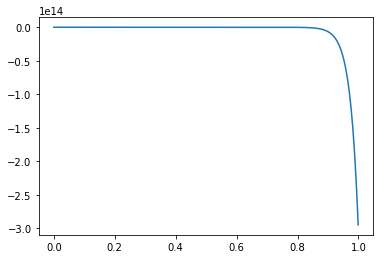

In [17]:
plt.plot(ts,th)

In [18]:
x_hat = np.array([[0],[0],[0],[0],[0],[-20*pi/180],[0]])
u = np.array([1])
k_e = control.place(A_mp,B_mp,E)
y_error = np.array([1])
k_e = k_e.T
k_e


array([[ 2.59459982e+01],
       [ 2.65956005e-01],
       [ 1.00417276e-01],
       [-1.25945998e+01],
       [-3.72659776e+01],
       [ 4.22809586e+02],
       [ 7.27293680e+01]])

In [19]:
k_e*y_error

array([[ 2.59459982e+01],
       [ 2.65956005e-01],
       [ 1.00417276e-01],
       [-1.25945998e+01],
       [-3.72659776e+01],
       [ 4.22809586e+02],
       [ 7.27293680e+01]])

In [20]:
K, S, E = control.lqr(motor_pendu.Gss, Qreg, Rreg)
K_e = control.place(A_mp,B_mp,E)
K_e = K_e.T

In [21]:
import control.matlab as cm

In [22]:
syst = motor_pendu.Gss
sysd = cm.c2d(syst, Ts = 0.0001)
print(sysd)

A = [[ 1.00000000e+00  9.95016593e-05  4.82120052e-08  0.00000000e+00
       0.00000000e+00  0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  9.90049738e-01  9.46804587e-04  0.00000000e+00
       0.00000000e+00  0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00 -1.89360917e-04  9.04837325e-01  0.00000000e+00
       0.00000000e+00  0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00 -3.74843178e-12 -1.21985851e-15  1.00000000e+00
       9.99981195e-05  1.55006849e-08  5.16691109e-13]
     [ 0.00000000e+00 -7.48434246e-08 -3.62644593e-11  0.00000000e+00
       9.99962391e-01  3.10011764e-04  1.55006849e-08]
     [ 0.00000000e+00 -1.05096221e-11 -3.42016408e-15  0.00000000e+00
      -5.27234179e-09  1.00000018e+00  1.00000006e-04]
     [ 0.00000000e+00 -2.09841387e-07 -1.01676057e-10  0.00000000e+00
      -1.05446178e-04  3.61685558e-03  1.00000018e+00]]

B = [[3.24348621e-10]
     [9.64240105e-06]
     [1.90325158e-02]
     [3.76093700e-10]
     [7.52182678e-06]
     [1.05446

In [23]:
np.linalg.matrix_rank(control.ctrb(sysd.A,sysd.B))

5

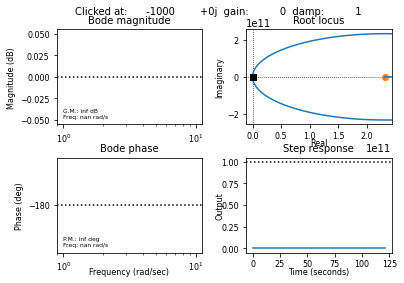

In [24]:
cstm = control.rootlocus_pid_designer(syst)

In [25]:
t = np.linspace(0,2,10000)
T, yout = control.step_response(cstm, t)

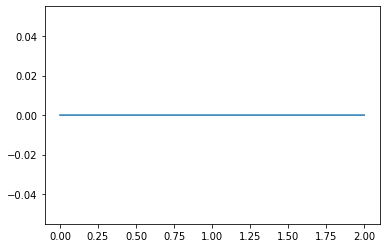

In [26]:
plt.plot(t,yout)

<h4> Using Luenberg Estimater

In [81]:
from control.matlab import acker,dare,care

In [173]:
Qreg = np.array([[0., 0., 0., 0., 0., 0., 0.],
                  [0., 0, 0., 0., 0., 0., 0.],
                  [0., 0., 1., 0., 0., 0., 0.],
                  [0., 0., 0., 1., 0., 0., 0.],
                  [0., 0., 0., 0., 1., 0., 0.],
                  [0., 0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 0., 1.]])
Rreg = 1
C_mp=np.array(C_mp)[0]

In [174]:
motor_pendu = motor_pendulum(A_mp,B_mp,C_mp,D_mp,x0)
 #finding the state gain matrix K
K, S, E = control.lqr(motor_pendu.Gss, Qreg, Rreg)
L = control.place(A_mp,B_mp,E)
L

matrix([[ 5.00097519e+01,  4.98799792e-01,  1.02816502e-01,
         -6.00097519e+00, -3.08563394e+01,  3.76384045e+02,
          6.47870367e+01]])

In [175]:
re = A_mp - np.matmul(L,C_mp)
eith = np.linalg.eigvals(re)
eith

array([-2.84527299e+03, -8.00416126e+02, -8.08939960e+01, -1.02332559e+01,
        2.23334640e+00,  3.81769881e-14, -4.81394738e-01])

In [176]:
E

array([-1.01978220e+03+0.j        , -1.00021360e+02+0.j        ,
       -6.12936709e+00+0.j        , -5.90535634e+00+0.j        ,
       -2.21530510e-15+0.j        , -2.21730611e-01+0.08255645j,
       -2.21730611e-01-0.08255645j])

In [140]:
def control_simulation_Kalman(motor_pendulum):
    
    ref_state = np.array([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    x_est = np.array([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    motor_pendulum.change_input(0.0)
    x_meas = np.array([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    theta = []
    position = []
    velocity = []
    omega = []
    x_pre = []
    for t in ts:
        
        th_meas = motor_pendulum.output
        x_meas[2,0]= th_meas
        x_est[2,0] = th_meas
        state_error = ref_state - x_est
        #print(state_error)

        x_est = (np.matmul(A_mp,x_est) + B_mp*np.dot(K[0],state_error).sum()  + np.matmul(L, x_meas-np.matmul(C_mp,x_est)))*dt +x_est
        x_pre.append(np.matmul(C_mp,x_est)[0,0])
        control_output = np.dot(K[0],state_error).sum()
        print(control_output)

        motor_pendulum.change_input(control_output)
        motor_pendulum.change_state(motor_pendulum.state + motor_pendulum.derivative(control_output)*dt)
    
        position.append(motor_pendulum.state[0])
        velocity.append(motor_pendulum.state[1])
        theta.append(motor_pendulum.state[2])
        omega.append(motor_pendulum.state[3])
        
    return np.array([position, velocity,theta,omega,x_pre])

In [141]:
sample_time = 10/1000
ref_angle = 0.0
ref_velocity = 0.0
ts = np.arange(0, 50, 10**(-3))
dt = ts[1]

In [142]:
motor_pendu = motor_pendulum(A_mp,B_mp,C_mp,D_mp,x0)
x,dx,th,dth,x_pre  = control_simulation_Kalman(motor_pendu)

3.9599805783474096e-06
2.6500755269049606e-05
4.115490691798272e-05
5.1191030438072186e-05
5.8519537216751376e-05
6.425631679594916e-05
6.905291149505533e-05
7.328952041009747e-05
7.718781618472326e-05
8.087688631541641e-05
8.443177258024451e-05
8.789599254252335e-05
9.129469797447182e-05
9.464236046974274e-05
9.794725838008545e-05
0.00010121409444428011
0.00010444552118336737
0.00010764302827696273
0.00011080745740080504
0.00011393929967832019
0.00011703886640718204
0.0001201063860246002
0.00012314205824122344
0.0001261460833960129
0.0001291186775592633
0.00013206007951441624
0.00013497055318148753
0.00013785038754591725
0.0001406998952822439
0.00014351941075254257
0.00014630928776328
0.00014906989729241652
0.00015180162529938518
0.00015450487067370853
0.00015718004334577614
0.0001598275625653696
0.00016244785534385263
0.0001650413550510275
0.0001676085001554464
0.00017014973309626964
0.0001726654992748898
0.00017515624615510003
0.00017762242246134306
0.00018006447746541526
0.00018248

/tmp/ipykernel_2578/2345927862.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([position, velocity,theta,omega,x_pre])


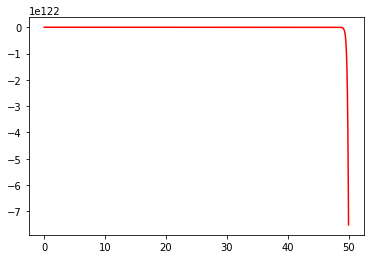

In [139]:
plt.plot(ts,x,"r")
#plt.xlim((0,3))